<a href="https://colab.research.google.com/github/minhvvan/DeepLearning/blob/main/DualLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size=0.2, random_state=42)

print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [2]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=2, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self,x):
    z = np.dot(x, self.w) + self.b
    return z

  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m   #가중치에 대한 평균 그레이디언트 계산
    b_grad = np.sum(err) / m    #절편에 대한 평균 그레이디언트 계산
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1,1) #타겟을 열벡터로 변환
    y_val = y_val.reshape(-1,1) #val타겟을 열벡터로 변환
    m = len(x)
    self.w = np.ones((x.shape[1],1))  #가중치 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  #가중치 기록

    for i in range(epochs):
      z = self.forpass(x) #정방향 계산
      a = self.activation(z) #활성화 함수
      err = -(y - a)
      w_grad, b_grad = self.backprop(x,err)  #역방향 계산
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m  #그레이디언트 패널티적용
      self.w -= self.lr * w_grad  #가중치 업데이트
      self.b -= self.lr * b_grad  #절편 업데이트
      self.w_history.append(self.w.copy()) #가중치 기록
      a = np.clip(a, 1e-10,1-1e-10) #클리핑
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #로그 손실과 규제 손실 적용
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)  #검증

  
  def predict(self, x):
    z = self.forpass(x)
    return z > 0

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10,1-1e-10) #클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(-1,1))

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)   #정방향 계산
    a = self.activation(z)  #활성화 함수
    a = np.clip(a, 1e-10,1-1e-10) #클리핑
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) #로그 손실, 규제 손실 더하여 기록


In [15]:
class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units  #은닉층 뉴런 개수
    self.w1 = None  #은닉층 가중치
    self.b1 = None  #은닉층 절편
    self.w2 = None  #출력층 가중치
    self.b2 = None  #출력층 절편
    self.a1 = None  #은닉층 활성화 출력
    self.losses = []  #훈련 손실
    self.val_losses = []  #검승 손실
    self.lr = learning_rate #학습률
    self.l1 = l1  #l1 규제
    self.l2 = l2  #l2 규제

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1 #첫 번쨰 층 선형식 계산
    self.a1 = self.activation(z1) #활성화 함수
    z2 = np.dot(self.a1, self.w2) + self.b2 #두번째 선형식 계산

    return z2

  def backprop(self, x, err):
    m = len(x)  #샘플 개수
    w2_grad = np.dot(self.a1.T, err) / m  #출력층 그레이디언트
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)  #시그모이드 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m  #은닉층 그레이디언트
    b1_grad = np.sum(err_to_hidden) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def init_weights(self, n_featuers):
    self.w1 = np.ones((n_featuers, self.units)) #(특성 개수, 은닉층 크기)
    self.b1 = np.zeros(self.units)  #은닉층 크기
    self.w2 = np.ones((self.units, 1)) #(은닉층 크기,1)
    self.b2 = 0

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1]) #가중치 초기화
    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10,1-1e-10) #클리핑
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) #로그 손실 추가
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def training(self, x, y, m):
    z = self.forpass(x) #정방향 계산
    a = self.activation(z)  #활성화 함수
    err = -(y - a)  #오차 계산
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    #그레이디언트 규제
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    #은닉층 가중치 절편 업데이트
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    #출력층 가중치 절편 업데이트
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad

    return a

  def reg_loss(self):
    #은닉층과 출력층의 가중치에 규제 적용
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [20]:
class RandomInitNetwork(DualLayer):
  def init_weights(self, n_featuers):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_featuers,self.units))  #(특성 개수, 은닉층 크기)
    self.b1 = np.zeros(self.units)  #은닉층 크기
    self.w2 = np.random.normal(0, 1, (self.units, 1))  #(은닉층 크기, 1)
    self.b2 = 0

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [ ]:
# single_layer = SingleLayer(l2=0.01)
# single_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val= y_val, epochs=10000)
# single_layer.score(x_val_scaled,y_val)

In [16]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val= y_val, epochs=20000)
dual_layer.score(x_val_scaled,y_val)


0.978021978021978

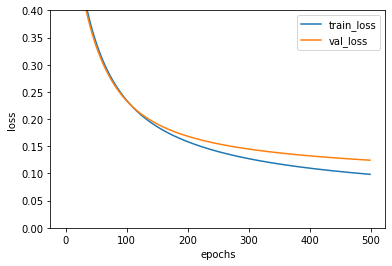

In [21]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val= y_val, epochs=500)
random_init_net.score(x_val_scaled,y_val)

plt.ylim(0, 0.4)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.ylim(0, 0.4)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

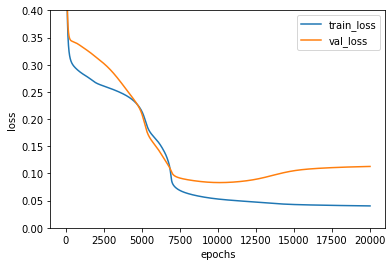

In [17]:
plt.ylim(0, 0.4)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])

plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()